# Problem Statement:
    
- a Machine Learning model that classifies a given line as belonging to one of the 12 novels already labelled.

# 1- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
! pip install version_information
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib

Software versions
Python 3.6.9 64bit [GCC 8.4.0]
IPython 5.5.0
OS Linux 4.19.112+ x86_64 with Ubuntu 18.04 bionic
pandas 1.0.5
numpy 1.18.5
nltk 3.2.5
seaborn 0.10.1
matplotlib 3.2.2
Fri Sep 04 12:09:29 2020 UTC

# 2-Loading Data

In [5]:
data_xtrain=pd.read_csv('xtrain_obfuscated.txt', header = None,sep=" " )
data_xtrain.columns = ["text"]
data_xtrain.shape

(32513, 1)

In [6]:
data_xtrain.head()

,text
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...


In [7]:
data_xtest=pd.read_csv('xtest_obfuscated.txt', header = None,sep=" " )
data_xtest.columns = ["text"]
data_xtest.shape

(3000, 1)

In [8]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [9]:
data_ytrain=pd.read_csv('ytrain.txt', header = None,sep=" " )
data_ytrain.columns = ["label"]
data_ytrain.shape

(32513, 1)

In [10]:
data_ytrain.head()

,label
0,7
1,3
2,8
3,3
4,4


In [11]:
data_ytrain.label.value_counts()

7     5097
6     4226
3     4023
8     3634
1     3459
10    3052
4     2337
5     2283
2     1471
11    1408
9      980
0      543
Name: label, dtype: int64

In [12]:
data_ytrain.label.value_counts(normalize=True)

7     0.156768
6     0.129979
3     0.123735
8     0.111771
1     0.106388
10    0.093870
4     0.071879
5     0.070218
2     0.045243
11    0.043306
9     0.030142
0     0.016701
Name: label, dtype: float64

# 3-Vectorize

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [14]:
x_train=data_xtrain.text
x_test=data_xtest.text

In [15]:
# using trigram and char as unit for analysis
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [16]:
#full_tfidf = tfidf_vec.fit_transform(train_data_x + test_data_x)
train_tfidf = tfidf_vec.fit_transform(x_train).toarray()
test_tfidf = tfidf_vec.transform(x_test).toarray()

In [17]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(32513, 3398)
(3000, 3398)


In [18]:
labels = data_ytrain.label.astype(str)

In [19]:
pd.DataFrame(train_tfidf).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,3375,3376,3377,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397
0,0.126480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.026665,0.0,0.0,0.026712,0.008209,0.0,0.008231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.095712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014032,0.0,0.0,0.020304,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.029217,0.0,0.0,0.0,0.029383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.026401,0.0,0.026472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.029377,0.0,0.0,0.029586,0.0,0.0,0.012498,0.0,0.0,0.0,0.012569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.015058,0.0,0.015098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025260,0.0,0.0,0.036550,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.038593,0.0,0.0,0.038662,0.015842,0.0,0.015884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.081580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.013290,0.0,0.0,0.013314,0.024549,0.0,0.024614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4-ML models

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
   
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_tfidf, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [21]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.629863
1,RandomForestClassifier,1,0.618638
2,RandomForestClassifier,2,0.624327
3,RandomForestClassifier,3,0.623193
4,RandomForestClassifier,4,0.620886
5,LinearSVC,0,0.764570
6,LinearSVC,1,0.749808
7,LinearSVC,2,0.752883
8,LinearSVC,3,0.754229
9,LinearSVC,4,0.748078


In [22]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.753914
LogisticRegression        0.661489
MultinomialNB             0.424446
RandomForestClassifier    0.623381
Name: accuracy, dtype: float64

# 5-Evaluate model

SVC is best performing model so we shall use it

In [23]:
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(train_tfidf, labels, x_train.index, test_size=0.20, random_state=0)

In [33]:
clf = LinearSVC()
clf.fit(X_train, y_train)
predictions = clf._predict_proba_lr(X_val)

In [38]:
print("Probability Distribution for 1st sample:",predictions[0])

Probability Distribution for 1st sample: [0.07345096 0.10450502 0.1150086  0.11768486 0.06947169 0.09195272
 0.05873446 0.08282828 0.06395387 0.06717633 0.0786052  0.07662801]


In [26]:
print("logloss: %0.3f " % metrics.log_loss(np.asarray(y_val), predictions))


logloss: 1.803 


In [28]:
# predict class type
y_pred = clf.predict(X_val)
y_pred[:5]

array(['11', '7', '1', '3', '5'], dtype=object)

In [30]:
# prediction values for class type
accuracy_value_class=predictions.max(axis=1)
accuracy_value_class[:5]

array([0.11768487, 0.17435597, 0.160474  , 0.16421679, 0.27930072])

In [31]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.7571889896970629


In [39]:
#Function for category id
data_ytrain['category_id'] = data_ytrain['label'].factorize()[0]
category_id_df = data_ytrain[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

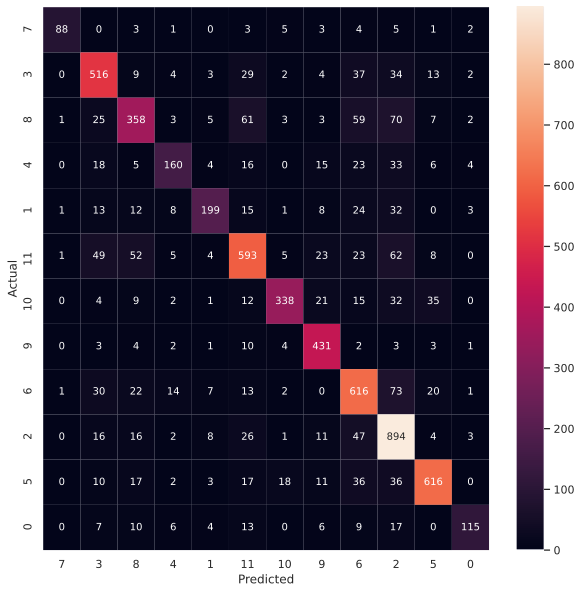

In [40]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [41]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       115
           1       0.75      0.79      0.77       653
          10       0.69      0.60      0.64       597
          11       0.77      0.56      0.65       284
           2       0.83      0.63      0.72       316
           3       0.73      0.72      0.73       825
           4       0.89      0.72      0.80       469
           5       0.80      0.93      0.86       464
           6       0.69      0.77      0.73       799
           7       0.69      0.87      0.77      1028
           8       0.86      0.80      0.83       766
           9       0.86      0.61      0.72       187

    accuracy                           0.76      6503
   macro avg       0.79      0.73      0.76      6503
weighted avg       0.76      0.76      0.76      6503



We calculated 

- Log_loss (lower is better)
- Accuracy 
- Precision
- Recall
- f1

# ML Model for Prediction on test dataset

In [42]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [43]:
labels.head()

0    7
1    3
2    8
3    3
4    4
Name: label, dtype: object

In [51]:
clf.fit(train_tfidf, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [52]:
y_pred = clf.predict(test_tfidf)
y_pred[:5]

array(['6', '11', '8', '8', '8'], dtype=object)

In [53]:
print(y_pred.shape)

(3000,)


In [54]:
# probability distribution acc. all 12 classes
prediction_df=pd.DataFrame(clf._predict_proba_lr(test_tfidf), columns=clf.classes_)
prediction_df[:5]

,0,1,10,11,2,3,4,5,6,7,8,9
0,0.075168,0.067180,0.067714,0.057420,0.057642,0.082979,0.065305,0.040997,0.234623,0.094901,0.062265,0.093804
1,0.029431,0.088391,0.081245,0.206996,0.075485,0.104373,0.060481,0.085047,0.098058,0.029675,0.062625,0.078192
2,0.053382,0.062175,0.105786,0.086154,0.111126,0.109070,0.107947,0.029048,0.049669,0.095432,0.128963,0.061247
3,0.031155,0.125015,0.021441,0.042419,0.059697,0.036248,0.125395,0.049418,0.142872,0.023649,0.271310,0.071381
4,0.057864,0.063223,0.097905,0.058901,0.103010,0.091668,0.130829,0.042778,0.081881,0.054069,0.157653,0.060220


In [55]:
accuracy_value_class=prediction_df.max(axis=1)

In [56]:
df_submit=data_xtest.copy()
df_submit["predicted_class"]=y_pred
df_submit["probability"]=accuracy_value_class
df_submit.head()

,text,predicted_class,probability
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...,6,0.234623
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...,11,0.206996
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...,8,0.128963
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...,8,0.271310
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...,8,0.157653


In [57]:
df_submit.shape

(3000, 3)